In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio

Sklearn $\ge$ 0.19 is necessary for the efficient implementation of tsne.

In [21]:
import sklearn.manifold  
sklearn.__version__

'0.19.0'

### Pull the data from the internet and write it to a file

In [2]:
%%time
results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
with open("coil20.zip", "wb") as code:
    code.write(results.content)

CPU times: user 313 ms, sys: 167 ms, total: 480 ms
Wall time: 5.07 s


### Read in from file and transform into a vector space

We add a filter to ensure that we only parse png files from our download zip.

In [8]:
import re
images_zip = zipfile.ZipFile('coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))

Next we pull the object id's from the file names using pandas

In [9]:
%%time
feature_vectors = []
for filename in [images_zip.filename+'/'+file for file in filelist]:
    im = imageio.imread(filename)
    feature_vectors.append(im.flatten())

CPU times: user 38 s, sys: 1.05 s, total: 39 s
Wall time: 39.4 s


### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

We could leave this data in numpy arrays for improved efficiency but at data sizes this small the added functionality of pandas for potential exploration is appealing.

In [10]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

In [11]:
data = pd.DataFrame(feature_vectors, index=labels)
data.shape

(1440, 16384)

### Now let's use UMAP to embed these points into a two dimensional space.

In [33]:
fit = umap.UMAP(n_neighbors=5, random_state=42, metric='euclidean')
%time u = fit.fit_transform(data)

CPU times: user 1min 1s, sys: 997 ms, total: 1min 2s
Wall time: 1min 5s


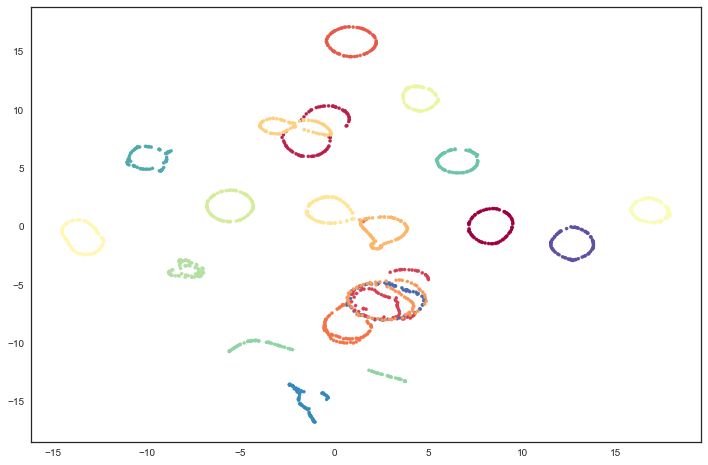

In [34]:
plt.scatter(u[:,0], u[:,1], c=labels, cmap="Spectral", s=10)

We see here that UMAP manages to preserve much of the loop structure that is inherent within the coil data set. The coil data set was constructed by taking 20 objects and photographing them at various rotations.  These rotations are being reveiled by the locality preserving property of UMAP.

TO DO: Look at the global structure in between the groups

### T-SNE

In [22]:
fit_tsne = sklearn.manifold.TSNE()
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 1min 4s, sys: 3.01 s, total: 1min 7s
Wall time: 1min 7s


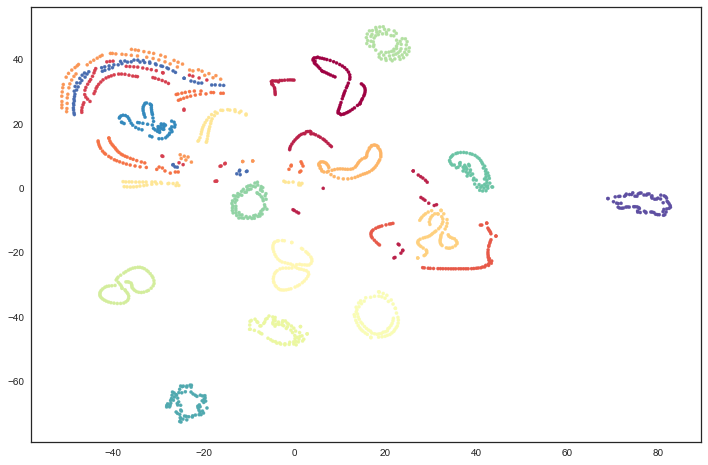

In [23]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], c=labels, cmap="Spectral", s=10)

t-SNE breaks more of the loops losing some of the loop structure inherent in COIL.  On the other hand it does a very good job of seperating the objects within COIL.

TO DO: Examine the global positioning of COIL objects.

## MDS

For old times sake we attempt to embed with multi-dimensional scaling

In [26]:
fit_mds = sklearn.manifold.MDS()
%time u_mds = fit_mds.fit_transform(data)

CPU times: user 2min 6s, sys: 20.6 s, total: 2min 27s
Wall time: 1min 35s


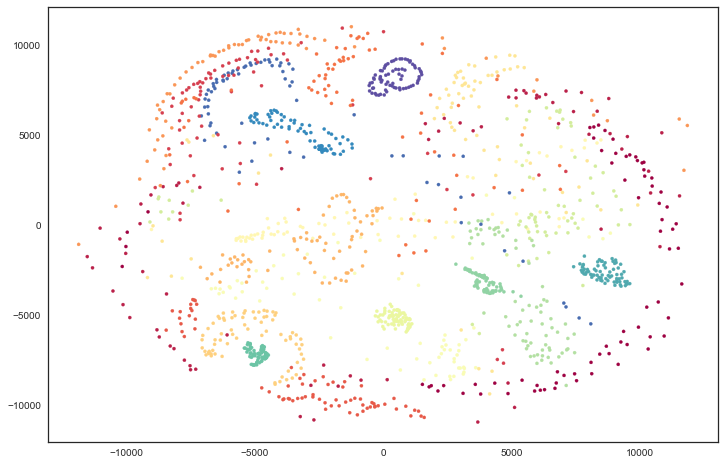

In [27]:
plt.scatter(u_mds[:,0], u_mds[:,1], c=labels, cmap="Spectral", s=10)

MDS and PCA (below) should do a better job preserving global structure at the expense of sacrificying local structure.  These can be seen in the loss of loop structure in our data and the dispersal of points across our space.

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 1.62 s, sys: 289 ms, total: 1.91 s
Wall time: 1.29 s


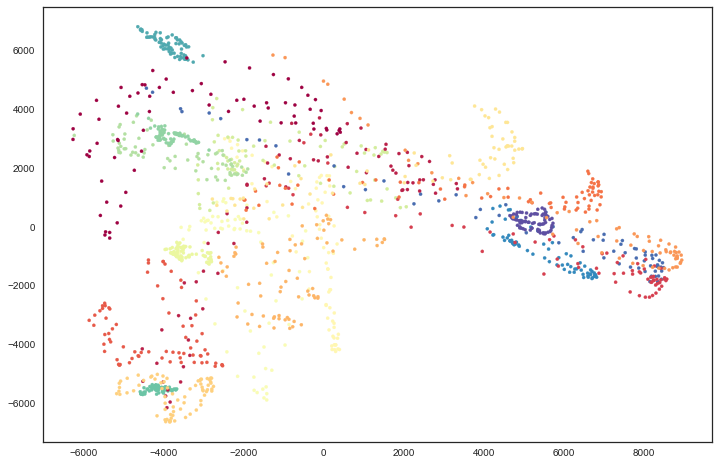

In [32]:
plt.scatter(u_pca[:,0], u_pca[:,1], c=labels, cmap="Spectral", s=10)

### ISOMAP 

Isomap should be to reveal some of the non-linear structure in our manifold where PCA and MDS had difficulties.

In [48]:
fit_isomap = sklearn.manifold.Isomap(n_neighbors=5)
%time u_isomap = fit_isomap.fit_transform(data)

CPU times: user 1min 7s, sys: 1.51 s, total: 1min 8s
Wall time: 1min 24s


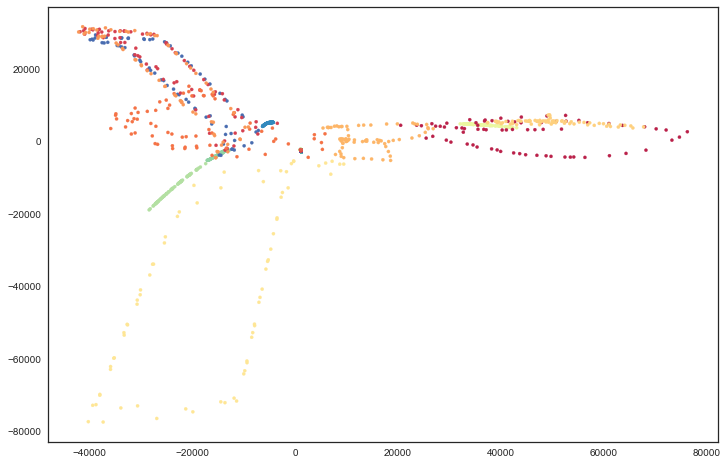

In [49]:
plt.scatter(u_isomap[:,0], u_isomap[:,1], c=labels, cmap="Spectral", s=10)

Isomap was able to identify some of the loop structure with COIL but is unable to separate the objects cleanly.  